# A2C Training for Dermatology Triage Clinic

**Reinforcement Learning Summative Assignment**

This notebook trains a Advantage Actor-Critic (A2C) agent on the custom dermatology clinic triage environment.

## Workflow:
1. **Setup**: Mount Drive, install dependencies
2. **Environment**: Embed ClinicEnv code
3. **Configurations**: Load 10 A2C hyperparameter configs
4. **Quick Sweep**: Train all 10 configs for 50K steps each
5. **Analysis**: Identify best performing configuration
6. **Full Training**: Train best config with 5 seeds for 200K steps
7. **Evaluation**: Generate plots and performance metrics
8. **Export**: Save models and results to Google Drive


## 1. Setup: Mount Google Drive & Install Dependencies


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory on Drive
import os
PROJECT_DIR = '/content/drive/MyDrive/RL_Summative'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models/a2c', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/logs/a2c', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/plots', exist_ok=True)

print(f"✓ Google Drive mounted")
print(f"✓ Project directory: {PROJECT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Project directory: /content/drive/MyDrive/RL_Summative


In [ ]:
# Install required packages
# NOTE: numpy 1.26.4 is specified to avoid binary incompatibility with torch
# Install numpy FIRST, then restart runtime before importing any libraries
%pip install -q numpy==1.26.4
%pip install -q torch
%pip install -q gymnasium
%pip install -q stable-baselines3
%pip install -q sb3-contrib
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q pandas
%pip install -q tqdm
%pip install -q imageio

print("\n" + "="*60)
print("✓ All packages installed successfully!")
print("="*60)
print("\n⚠️  IMPORTANT: RESTART RUNTIME NOW")
print("Click 'Runtime' → 'Restart runtime' in the menu above")
print("Then run ALL cells again from the beginning")
print("="*60)


✓ All packages installed successfully!

⚠️  IMPORTANT: RESTART RUNTIME NOW
Click 'Runtime' → 'Restart runtime' in the menu above
Then run ALL cells again from the beginning


In [ ]:
# Import libraries
import gymnasium as gym
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from typing import Tuple, Dict, Any, Optional, List
from tqdm.notebook import tqdm
from gymnasium import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2. Embed ClinicEnv (Custom Gymnasium Environment)


In [ ]:
class ClinicEnv(gym.Env):
    """
    Clinic triage environment (vector-based).
    Obs: [age, duration, fever, infection, 8 symptom dims, room_avail, queue_len, time_of_day] (15,)
    Actions (Discrete 8): 0=doctor,1=nurse,2=remote,3=escalate,4=defer,5=idle,6=open_room,7=close_room
    """
    metadata = {"render_modes": ["rgb_array"], "render_fps": 6}

    def __init__(self, seed: int = 0, max_steps: int = 500):
        super().__init__()
        self.seed(seed)
        self.max_steps = max_steps
        # FIX: Changed shape from (14,) to (15,) to match the actual observation vector
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(15,), dtype=np.float32)
        self.action_space = spaces.Discrete(8)

        # internal state
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = []
        self.current_patient = None
        self.total_wait = 0.0
        self.last_render = None

        # reward tuning defaults
        self.wrong_penalty_base = -2.0
        self.severity_multiplier = {0:1.0, 1:1.2, 2:1.6, 3:2.2}
        self.resource_cost_scale = -0.02
        self.wait_penalty_scale = -0.01
        self.critical_fast_threshold = 5

        # Initialize directly
        self._reset_internal()

    def seed(self, seed=None):
        self._seed = seed
        random.seed(seed)
        np.random.seed(seed)
        return [seed]

    def _sample_patient(self) -> Dict[str, Any]:
        severity = int(np.random.choice([0,1,2,3], p=[0.4,0.35,0.2,0.05]))
        age_norm = float(np.clip(np.random.normal(0.5, 0.15), 0.0, 1.0))
        duration_norm = float(np.clip(np.random.exponential(0.5), 0.0, 1.0))
        fever_flag = 1.0 if (np.random.rand() < (0.05 + 0.2*severity)) else 0.0
        infection_flag = 1.0 if (np.random.rand() < (0.05 + 0.25*severity)) else 0.0
        base = 0.2 + 0.25*severity
        symptom_embed = np.clip(np.random.normal(loc=base, scale=0.08, size=(8,)), 0.0, 1.0)
        return {
            "severity": severity,
            "age_norm": age_norm,
            "duration_norm": duration_norm,
            "fever_flag": fever_flag,
            "infection_flag": infection_flag,
            "symptom_embed": symptom_embed,
            "wait_time": 0.0
        }

    def _form_observation(self, patient: Dict[str,Any]) -> np.ndarray:
        vec = [
            patient["age_norm"],
            patient["duration_norm"],
            patient["fever_flag"],
            patient["infection_flag"],
        ]
        vec += list(patient["symptom_embed"])
        vec += [
            1.0 if self.num_open_rooms > 0 else 0.0,
            np.clip(len(self.queue) / 10.0, 0.0, 1.0),
            np.clip(self.step_count / self.max_steps, 0.0, 1.0)
        ]
        # This vector has length 15 (4 + 8 + 3)
        return np.array(vec, dtype=np.float32)

    def _reset_internal(self):
        self.step_count = 0
        self.num_open_rooms = 1
        self.queue = [self._sample_patient() for _ in range(3)]
        self.current_patient = None
        self.total_wait = 0.0
        self._maybe_spawn_next()

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)
        self._reset_internal()
        obs = self._form_observation(self.current_patient)
        info = {}
        # Gym API: reset must return (obs, info)
        return obs, info

    def _maybe_spawn_next(self):
        if self.current_patient is None and len(self.queue) > 0:
            self.current_patient = self.queue.pop(0)
        elif self.current_patient is None:
            self.current_patient = self._sample_patient()

    def step(self, action: int):
        assert self.action_space.contains(action), "Invalid action"
        self.step_count += 1

        terminated = False
        truncated = False
        info: Dict[str,Any] = {}
        patient = self.current_patient
        reward = 0.0

        # correct action mapping
        if patient["severity"] == 0:
            correct_action = 2
        elif patient["severity"] == 1:
            correct_action = 1
        elif patient["severity"] == 2:
            correct_action = 0
        else:
            correct_action = 3

        # triage reward / penalty
        if action == correct_action:
            if patient["severity"] == 0:
                reward += 1.0
            elif patient["severity"] == 1:
                reward += 1.25
            elif patient["severity"] == 2:
                reward += 2.0
            else:
                reward += 3.0 if patient["wait_time"] < self.critical_fast_threshold else 2.0
        else:
            mult = self.severity_multiplier.get(patient["severity"], 1.0)
            reward += self.wrong_penalty_base * mult

        # action effects
        if action == 6:
            self.num_open_rooms += 1
        if action == 7 and self.num_open_rooms > 0:
            self.num_open_rooms -= 1
        if action == 4:
            patient["wait_time"] += 1.0
            self.queue.append(patient)
            self.current_patient = None
        else:
            self.current_patient = None

        # queue wait penalty increment
        wait_increment = 0.01 * len(self.queue)
        for p in self.queue:
            p["wait_time"] += 1.0
        self.total_wait += wait_increment
        reward += self.wait_penalty_scale * wait_increment

        # resource cost
        reward += self.resource_cost_scale * max(0, self.num_open_rooms)

        # clip reward
        reward = float(np.clip(reward, -6.0, 6.0))

        # spawn next patient
        self._maybe_spawn_next()

        obs = self._form_observation(self.current_patient)

        # Check termination
        if self.step_count >= self.max_steps:
            truncated = True

        info["current_severity"] = int(patient["severity"])
        info["correct_action"] = int(correct_action)
        info["num_open_rooms"] = int(self.num_open_rooms)
        info["queue_length"] = len(self.queue)
        info["triage_reward_component"] = float(reward)

        # Gym API: step must return (obs, reward, terminated, truncated, info)
        return obs, reward, terminated, truncated, info

    def render(self, mode="rgb_array") -> np.ndarray:
        H, W = 240, 360
        canvas = np.ones((H, W, 3), dtype=np.uint8) * 255
        sev = self.current_patient["severity"] if self.current_patient else 0
        sev_norm = sev / 3.0
        color = np.array([int(255 * sev_norm), int(180 * (1 - sev_norm)), 60], dtype=np.uint8)
        canvas[20:200, 20:60] = color
        q_len = len(self.queue)
        q_h = min(q_len * 15, 150)
        canvas[20:20+q_h, 80:100] = [80, 80, 255]
        r = self.num_open_rooms
        r_h = min(r * 20, 150)
        canvas[20:20+r_h, 120:140] = [50, 200, 50]
        sym = self.current_patient["symptom_embed"] if self.current_patient else np.zeros(8)
        for i, val in enumerate(sym):
            x0 = 160 + i*20
            height = int(120 * val)
            canvas[150-height:150, x0:x0+12] = [int(100+150*val), int(100*(1-val)), int(50)]
        self.last_render = canvas
        return canvas

## 3. Load A2C Configurations (10 Hyperparameter Sets)


In [ ]:
# Embedded A2C configurations
A2C_CONFIGS = {
  "configs": [
    {
      "id": "a2c_baseline",
      "description": "Baseline A2C configuration",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": True
    },
    {
      "id": "a2c_high_lr",
      "description": "Higher learning rate",
      "learning_rate": 0.001,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_low_lr",
      "description": "Lower learning rate for stability",
      "learning_rate": 0.0003,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_longer_rollout",
      "description": "Longer n-step rollouts",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 16,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_short_rollout",
      "description": "Very short rollouts for fast updates",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 3,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_high_entropy",
      "description": "Higher entropy for exploration",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.05,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_no_entropy",
      "description": "Zero entropy for exploitation",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.0,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_high_vf_coef",
      "description": "Higher value function coefficient",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 1.0,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    },
    {
      "id": "a2c_normalized",
      "description": "With advantage normalization",
      "learning_rate": 0.0007,
      "gamma": 0.99,
      "n_steps": 5,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": True
    },
    {
      "id": "a2c_high_gamma",
      "description": "Higher discount factor for long-term planning",
      "learning_rate": 0.0007,
      "gamma": 0.995,
      "n_steps": 8,
      "gae_lambda": 1.0,
      "ent_coef": 0.01,
      "vf_coef": 0.5,
      "max_grad_norm": 0.5,
      "normalize_advantage": False
    }
  ]
}

configs = A2C_CONFIGS["configs"]
print(f"✓ Loaded {len(configs)} A2C configurations")
for cfg in configs:
    print(f"  - {cfg['id']}: {cfg['description']}")


✓ Loaded 10 A2C configurations
  - a2c_baseline: Baseline A2C configuration
  - a2c_high_lr: Higher learning rate
  - a2c_low_lr: Lower learning rate for stability
  - a2c_longer_rollout: Longer n-step rollouts
  - a2c_short_rollout: Very short rollouts for fast updates
  - a2c_high_entropy: Higher entropy for exploration
  - a2c_no_entropy: Zero entropy for exploitation
  - a2c_high_vf_coef: Higher value function coefficient
  - a2c_normalized: With advantage normalization
  - a2c_high_gamma: Higher discount factor for long-term planning


In [ ]:
def evaluate_agent(model, env, num_episodes=20, deterministic=True):
    """Evaluate trained agent and return metrics."""
    episode_rewards = []
    episode_lengths = []
    triage_accuracies = []

    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        episode_reward = 0.0
        episode_length = 0
        correct = 0
        total = 0

        while not done:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            episode_reward += reward
            episode_length += 1

            if 'correct_action' in info:
                total += 1
                if action == info['correct_action']:
                    correct += 1

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        if total > 0:
            triage_accuracies.append(100.0 * correct / total)

    return {
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
        "mean_length": np.mean(episode_lengths),
        "mean_triage_accuracy": np.mean(triage_accuracies) if triage_accuracies else 0.0,
        "std_triage_accuracy": np.std(triage_accuracies) if triage_accuracies else 0.0
    }

def train_a2c_config(config, env, total_timesteps=50000, seed=42, verbose=False):
    """Train A2C with given configuration."""

    env.reset(seed=seed)

    model = A2C(
        "MlpPolicy",
        env,
        # A2C-specific hyperparameters
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        n_steps=config["n_steps"],
        gae_lambda=config["gae_lambda"],
        ent_coef=config["ent_coef"],
        vf_coef=config["vf_coef"],
        max_grad_norm=config["max_grad_norm"],
        normalize_advantage=config["normalize_advantage"],
        # General parameters
        seed=seed,
        verbose=0
    )

    model.learn(total_timesteps=total_timesteps)

    # Evaluate
    eval_results = evaluate_agent(model, env, num_episodes=20)

    return model, eval_results

def save_results_to_csv(results, filename):
    """Save training results to CSV."""
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"✓ Results saved to {filename}")

def plot_config_comparison(results_df, save_path=None):
    """Plot comparison of all configurations."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Mean reward comparison
    ax1 = axes[0]
    sorted_df = results_df.sort_values('mean_reward', ascending=False)
    bars = ax1.barh(sorted_df['config_id'], sorted_df['mean_reward'],
                    color='steelblue', alpha=0.8)
    ax1.set_xlabel('Mean Reward', fontsize=12)
    ax1.set_title('Configuration Performance Comparison', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')

    # Triage accuracy comparison
    ax2 = axes[1]
    bars = ax2.barh(sorted_df['config_id'], sorted_df['triage_accuracy'],
                    color='coral', alpha=0.8)
    ax2.set_xlabel('Triage Accuracy (%)', fontsize=12)
    ax2.set_title('Triage Accuracy by Configuration', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to {save_path}")

    plt.show()

print("✓ Helper functions defined!")


✓ Helper functions defined!


## 5. Quick Sweep: Train All 10 Configs (50K steps each)

**Purpose**: Identify the best-performing configuration before committing to full training.

**Runtime**: ~2-3 hours on Colab GPU


In [ ]:
# Quick sweep training
print("="*60)
print("QUICK SWEEP: Training all 10 configurations")
print("="*60)

sweep_results = []
sweep_models = {}

for i, config in enumerate(configs):
    print(f"\n[{i+1}/10] Training: {config['id']}")
    print(f"Description: {config['description']}")
    print("-" * 60)

    # Create environment
    env = ClinicEnv(seed=42, max_steps=500)

    start_time = time.time()

    # Train
    try:
        model, eval_results = train_a2c_config(
            config, env,
            total_timesteps=100000,
            seed=42
        )

        elapsed = time.time() - start_time

        # Store results
        result = {
            "config_id": config["id"],
            "mean_reward": eval_results["mean_reward"],
            "std_reward": eval_results["std_reward"],
            "triage_accuracy": eval_results["mean_triage_accuracy"],
            "mean_length": eval_results["mean_length"],
            "learning_rate": config["learning_rate"],
            "gamma": config["gamma"],
            "n_steps": config["n_steps"],
            "training_time_sec": elapsed
        }

        sweep_results.append(result)
        sweep_models[config["id"]] = model

        print(f"✓ Completed in {elapsed:.1f}s")
        print(f"  Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
        print(f"  Triage Accuracy: {eval_results['mean_triage_accuracy']:.1f}%")

        # Save model to Drive
        model_path = f"{PROJECT_DIR}/models/a2c/{config['id']}_sweep.zip"
        model.save(model_path)
        print(f"  Model saved: {model_path}")

    except Exception as e:
        print(f"✗ Error training {config['id']}: {str(e)}")
        continue

    env.close()

print("\n" + "="*60)
print("SWEEP COMPLETE!")
print("="*60)

QUICK SWEEP: Training all 10 configurations

[1/10] Training: a2c_baseline
Description: Baseline A2C configuration
------------------------------------------------------------
✓ Completed in 338.7s
  Mean Reward: -41.94 ± 50.73
  Triage Accuracy: 74.0%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_baseline_sweep.zip

[2/10] Training: a2c_high_lr
Description: Higher learning rate
------------------------------------------------------------
✓ Completed in 320.4s
  Mean Reward: -7.67 ± 43.18
  Triage Accuracy: 75.7%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_high_lr_sweep.zip

[3/10] Training: a2c_low_lr
Description: Lower learning rate for stability
------------------------------------------------------------
✓ Completed in 326.9s
  Mean Reward: -39.89 ± 44.79
  Triage Accuracy: 74.1%
  Model saved: /content/drive/MyDrive/RL_Summative/models/a2c/a2c_low_lr_sweep.zip

[4/10] Training: a2c_longer_rollout
Description: Longer n-step rollouts
-------

## 6. Analyze Results & Select Best Configuration


✓ Results saved to /content/drive/MyDrive/RL_Summative/results/a2c_sweep_results.csv

SWEEP RESULTS (sorted by mean reward)
         config_id  mean_reward  triage_accuracy  training_time_sec
a2c_longer_rollout     501.0297            94.99         239.847169
  a2c_high_entropy      -4.7678            75.78         315.981498
       a2c_high_lr      -7.6653            75.65         320.412578
    a2c_high_gamma     -17.8753            75.02         276.434833
 a2c_short_rollout     -25.5053            74.51         397.726119
  a2c_high_vf_coef     -38.8003            74.17         315.373984
        a2c_low_lr     -39.8903            74.12         326.876552
      a2c_baseline     -41.9353            74.01         338.709346
    a2c_normalized     -41.9353            74.01         325.317329
    a2c_no_entropy     -44.4928            73.84         319.763694
✓ Plot saved to /content/drive/MyDrive/RL_Summative/plots/a2c_sweep_comparison.png


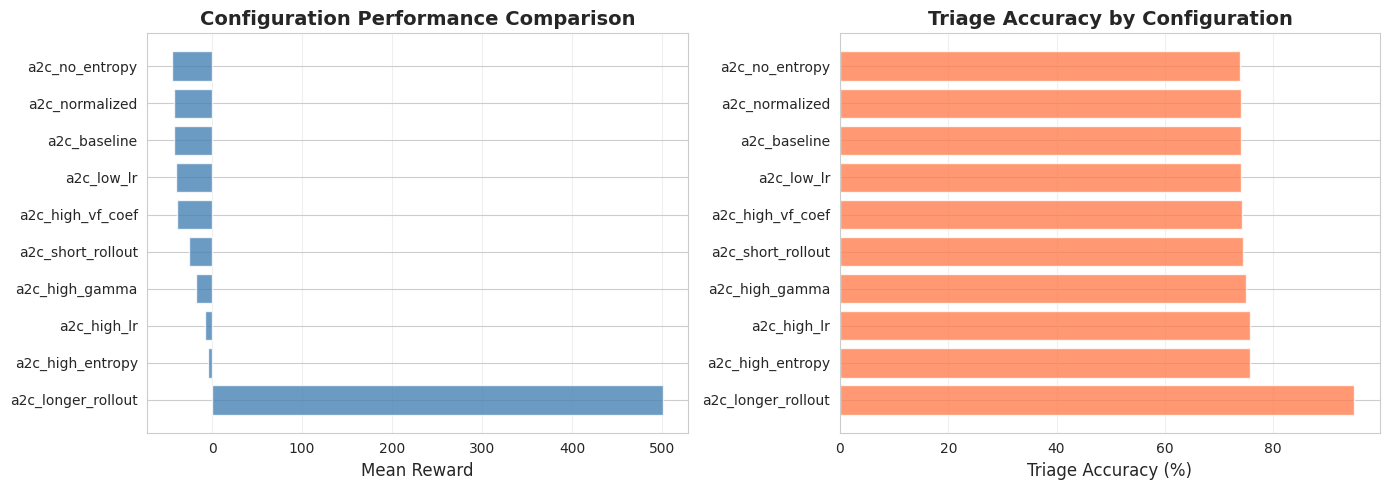


🏆 BEST CONFIGURATION: a2c_longer_rollout
   Mean Reward: 501.03
   Triage Accuracy: 95.0%

   Hyperparameters:
     learning_rate: 0.0007
     gamma: 0.99
     n_steps: 16
     ent_coef: 0.01


In [ ]:
# Create results dataframe
sweep_df = pd.DataFrame(sweep_results)

# Save sweep results
sweep_csv_path = f"{PROJECT_DIR}/results/a2c_sweep_results.csv"
save_results_to_csv(sweep_results, sweep_csv_path)

# Display sorted results
print("\n" + "="*60)
print("SWEEP RESULTS (sorted by mean reward)")
print("="*60)
print(sweep_df.sort_values('mean_reward', ascending=False)[
    ['config_id', 'mean_reward', 'triage_accuracy', 'training_time_sec']
].to_string(index=False))
print("="*60)

# Plot comparison
plot_config_comparison(
    sweep_df,
    save_path=f"{PROJECT_DIR}/plots/a2c_sweep_comparison.png"
)

# Identify best config
best_config_id = sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'config_id']
best_config = next(c for c in configs if c['id'] == best_config_id)

print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
print(f"   Mean Reward: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'mean_reward']:.2f}")
print(f"   Triage Accuracy: {sweep_df.loc[sweep_df['mean_reward'].idxmax(), 'triage_accuracy']:.1f}%")
print(f"\n   Hyperparameters:")
for key in ['learning_rate', 'gamma', 'n_steps', 'ent_coef']:
    print(f"     {key}: {best_config[key]}")
